This notebook implements filtering method for Range Query and K Nearest Neighbor (KNN) Query for trajectories. 
<br> The Range query searches for trajectories intersects with certain region, the KNN query searches for k trajectories that are most similar to the queried trajectory
<br>
<br> The filtering methods for Range Query is based on standard R tree, which stores spatial data points, and a mapping table, which maps each spatial point to its trajectory. To answer the query, spatial points that falling in the queried region are found first, then trajectories can be got from the mapping table. Such filtering method is from paper **[A Survey on Trajectory Data Management, Analytics, and Learning](https://dl.acm.org/doi/abs/10.1145/3440207?casa_token=tgWxx9HB74IAAAAA:355HzTdWPihskkv9Jdrb295eV_YFu5md-r5O9xaBcB4U_OI_gaIqCNM85ZtVFqxoNkDfjDrJaX2ZTA)**
<br> 
<br> For KNN Queries, the first issue is to define a distance measurements to measure the “similarities”. With various metrics exist, this notebook uses EDR distance, namely Edit Distance on Real Sequence, which is proposed from paper **[Robust and Fast Similarity Search for Moving Object Trajectories](https://dl.acm.org/doi/abs/10.1145/1066157.1066213?casa_token=RuMLiW3d9q4AAAAA:62IkecVUAm9Z5L2NmkReMhuaVl_-Y-vSIw00wB6OeTTluQo9tww2wy9Ew16On7aYbrqx2lhuZU8baw)** The built filtering method is also from the paper.




In [390]:
from rtree import index
import os
import json
import pandas as pd
import numpy as np
from haversine import haversine, Unit
from sklearn.cluster import KMeans
import math
import geopy
from geopy.distance import geodesic

In [91]:
from platform import python_version
python_version()

'3.11.3'

# Using Python's rtree library https://rtree.readthedocs.io/en/latest/

In [92]:
root_path = '/Users/osako15/Desktop/GPS_Path/Code/Geolife_Trajectories_1.3/Data'

user_list = []

for f in os.listdir(root_path):
    if len(f) == 3:
        user_list.append(f)

In [93]:
len(user_list)

182

In [112]:
def read_trajectory(file_path, trajectroy):
    global num_pts
    f = open(file_path, 'r')
    count = 1
    while count <= 6:
        f.readline()
        count += 1
    while True:
        line = f.readline()
        if not line:
            break
        line_list = line.split(",")
        lon = float(line_list[1])
        lat = float(line_list[0])
        num_pts += 1
        t = line_list[-2] + ' ' + line_list[-1]
        pt_id = num_pts
        trajectroy.append([pt_id,lat,lon,t])
    f.close()

In [113]:
Trajectoies = {}

num_pts = 0
num_trj = 0

for user in user_list:
    user_path = root_path + '/' + user + '/' + 'Trajectory'
    for f in os.listdir(user_path):
        file_path = user_path + '/' + f
        tra_data = []
        read_trajectory(file_path, tra_data)
        tra_id = num_trj
        # tra_id = num_tra
        Trajectoies[tra_id] = tra_data
        num_trj += 1
        

In [133]:
len(Trajectoies)

18670

# let us check if there are any outlier measures

In [217]:
lats = []
lons = []
tra_id = []
pt_id = []
record_time = []

for i in Trajectoies.items():
    for j in i[1]:
        tra_id.append(i[0])
        pt_id.append(j[0])
        lats.append(j[1])
        lons.append(j[2])
        record_time.append(j[3])

In [220]:
traj_df = pd.DataFrame({'trj_id': tra_id, 'pt_id': pt_id, 'lat': lats, 'lon': lons, 'time':record_time})

In [221]:
traj_df.shape

(24876978, 5)

In [225]:
traj_df

,trj_id,pt_id,lat,lon,time
0,0,1,39.974294,116.399741,2009-01-03 01:21:34\n
1,0,2,39.974292,116.399592,2009-01-03 01:21:35\n
2,0,3,39.974309,116.399523,2009-01-03 01:21:36\n
3,0,4,39.974320,116.399588,2009-01-03 01:21:38\n
4,0,5,39.974365,116.399730,2009-01-03 01:21:39\n
...,...,...,...,...,...
24876973,18669,24876974,39.973817,116.324117,2007-07-23 10:02:17\n
24876974,18669,24876975,39.973333,116.323683,2007-07-23 10:03:24\n
24876975,18669,24876976,39.973733,116.323250,2007-07-23 10:03:58\n
24876976,18669,24876977,39.973317,116.322967,2007-07-23 10:05:09\n


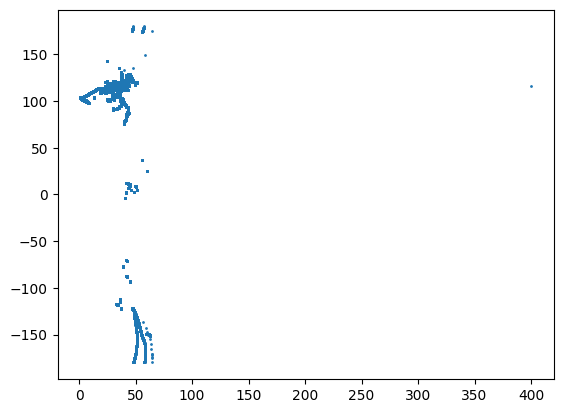

In [146]:
plt.scatter(lats, lons, s=1)
plt.show()

In [226]:
traj_df2 = traj_df[traj_df['lat'] > 100]

In [227]:
len(traj_df2)

1

In [228]:
traj_df2

,trj_id,pt_id,lat,lon,time
16650486,13898,16650487,400.166667,116.21539,2011-09-11 03:23:54\n


In [236]:
traj_df3 = traj_df[traj_df['trj_id'] != 13898]

In [237]:
len(traj_df3)

24854983

In [238]:
len(traj_df)

24876978

In [239]:
traj_df3

,trj_id,pt_id,lat,lon,time
0,0,1,39.974294,116.399741,2009-01-03 01:21:34\n
1,0,2,39.974292,116.399592,2009-01-03 01:21:35\n
2,0,3,39.974309,116.399523,2009-01-03 01:21:36\n
3,0,4,39.974320,116.399588,2009-01-03 01:21:38\n
4,0,5,39.974365,116.399730,2009-01-03 01:21:39\n
...,...,...,...,...,...
24876973,18669,24876974,39.973817,116.324117,2007-07-23 10:02:17\n
24876974,18669,24876975,39.973333,116.323683,2007-07-23 10:03:24\n
24876975,18669,24876976,39.973733,116.323250,2007-07-23 10:03:58\n
24876976,18669,24876977,39.973317,116.322967,2007-07-23 10:05:09\n


# Let us take a sample of 500 trajectories for test

In [407]:

test_traj_id = np.random.choice(18670, 500, replace=False)
len(test_traj_id)

500

In [411]:
len(np.unique(test_traj_id))

500

In [413]:
test_df = pd.DataFrame()

for test_id in test_traj_id:

    test_df = pd.concat([test_df, traj_df3[traj_df3['trj_id'] == test_id]], ignore_index=True)

In [414]:
len(test_df)

582494

## Keep a dict of trj_id：list of lats and lons

In [415]:
test_dict = {}
for test_id in test_traj_id:
    lats = np.array(test_df[test_df['trj_id'] == test_id]['lat'])
    lons = np.array(test_df[test_df['trj_id'] == test_id]['lon'])
    lats = lats.reshape((1, len(lats)))
    lons = lons.reshape((1, len(lons)))
    ppp = np.concatenate((lats.T, lons.T), axis=1)
    test_dict[test_id] = ppp

## Given a point (lat, lon), calculate a bounding box whose area is within e

In [392]:
def get_distance_box(lat, lon, dis=30):
    origin = geopy.Point(lat, lon)
    sw_pt = geodesic(meters=dis).destination(origin, 225)
    ne_pt = geodesic(meters=dis).destination(origin, 45)
    return ((sw_pt[0], sw_pt[1]), (ne_pt[0], ne_pt[1]))

# The EDR

In [588]:
def s_edr(t0, t1, eps=30):
    n0 = len(t0)
    n1 = len(t1)
    # An (m+1) times (n+1) matrix
    C = [[0] * (n1 + 1) for _ in range(n0 + 1)]
    for a in range(n1+1):
        C[0][a] = a
    for b in range(n0+1):
        C[b][0] = b
        
    for i in range(1, n0 + 1):
        for j in range(1, n1 + 1):
            if haversine((t0[i-1][0], t0[i-1][1]), (t1[j-1][0], t1[j-1][1]), unit=Unit.METERS) < eps:
                subcost = 0
            else:
                subcost = 1
            C[i][j] = min(C[i][j - 1] + 1, C[i - 1][j] + 1, C[i - 1][j - 1] + subcost)
    norm_edr = float(C[n0][n1]) / max([n0, n1])
    
    #edr = C[n0][n1]
    return norm_edr, C[n0][n1]

# The Q gram

In [293]:
def compute_mean_Qgrams(lats, lons, q = 5):
    mean_Qgrams = []
    for i in range(len(lats)-q+1):
        Qgram_lats = []
        Qgram_lons = []
        for j in range(q):
            Qgram_lats.append(lats[i+j])
            Qgram_lons.append(lons[i+j])
        lat_mean = np.mean(Qgram_lats)
        lon_mean = np.mean(Qgram_lons)
        mean_Qgrams.append([lat_mean, lon_mean])
    return mean_Qgrams

## Compute Q gram for all test traj

In [437]:
Point_Q_list = []
Q_grams_list = []
traj_id_list = []
test_traj_Q_counter = {}
Q_index = []

Q_num = 1
for test_id in test_traj_id:
    lats = np.array(test_df[test_df['trj_id'] == test_id]['lat'])
    lons = np.array(test_df[test_df['trj_id'] == test_id]['lon'])
    q_grams = compute_mean_Qgrams(lats, lons)
    for q in q_grams:
        Point_Q_list.append(Point(q[0], q[1]))
        Q_index.append(Q_num)
        Q_num += 1
    Q_grams_list += q_grams
    traj_id_list += [test_id] * len(q_grams)
    
    test_traj_Q_counter[test_id] = 0

In [442]:
len(Point_Q_list)

580495

In [443]:
Q_gram_df = pd.DataFrame({'trj_id': traj_id_list, 'Q_gram_index':Q_index, 'Q_gram_lat': Q_gram_array[:,0], 'Q_gram_lon':Q_gram_array[:,1]})

In [496]:
list(Q_gram_df[Q_gram_df['Q_gram_index']==6658]['trj_id'])[0]

6268

## Put all Q grams into R tree

In [460]:
s = geopandas.GeoSeries(Point_Q_list,index = Q_index, crs=4326)

### Get Q grams from query trajectory

In [450]:
query_traj_id = 112
query_traj_lats = np.array(traj_df3[traj_df3['trj_id'] == query_traj_id]['lat'])
query_traj_lons = np.array(traj_df3[traj_df3['trj_id'] == query_traj_id]['lon'])
query_q_grams = compute_mean_Qgrams(query_traj_lats, query_traj_lons)

In [452]:
len(query_q_grams)

674

In [454]:
box_sw, box_ne = get_distance_box(39.98600292, 116.36223294000001)

In [462]:
len(s.sindex.query(box(box_sw[0], box_sw[1], box_ne[0], box_ne[1])))

73

In [473]:
s.index[s.sindex.query(box(box_sw[0], box_sw[1], box_ne[0], box_ne[1]))]

Index([107981, 446126, 321437,  20648, 503196,  64343, 426434, 529742, 570395,
        69396,  21371, 530411, 336124, 212307,  99709,  79553, 188455, 511621,
       411561,  22136, 143697, 140918, 119833, 234715, 321436, 107980, 367550,
       503195,  20647, 530412, 336123, 145405, 570396, 426435,  64344,  69397,
       401310,  19675, 105584, 462540, 469680, 511620, 343111, 321435,  22135,
       188456, 212308, 535118, 107979, 140917, 570397,  21372, 143696, 426436,
       570398,  94331, 411560, 234716, 503194, 321434, 530413, 336122,  20646,
       511619, 461058, 446125, 408762, 122087,  69398,  64345, 107978, 104214,
       321433],
      dtype='int64')

In [497]:
for q_gram in query_q_grams:
    box_sw, box_ne = get_distance_box(q_gram[0], q_gram[1], dis=30)
    matched_Q_index_list = s.index[s.sindex.query(box(box_sw[0], box_sw[1], box_ne[0], box_ne[1]))]
    for q in matched_Q_index_list:
        traj_id = list(Q_gram_df[Q_gram_df['Q_gram_index'] == q]['trj_id'])[0]
        test_traj_Q_counter[traj_id] += 1

In [501]:

sorted_Q_Counter = sorted(test_traj_Q_counter.items(), key = lambda x:x[1], reverse = True)


In [506]:
sorted_Q_Counter

[(522, 1519),
 (6038, 1045),
 (14271, 946),
 (12274, 939),
 (14681, 825),
 (500, 747),
 (4423, 733),
 (5727, 662),
 (547, 654),
 (6061, 597),
 (802, 586),
 (14607, 571),
 (552, 569),
 (540, 569),
 (4474, 550),
 (6115, 523),
 (5954, 487),
 (4475, 461),
 (15283, 452),
 (15783, 437),
 (7797, 435),
 (17961, 424),
 (15887, 420),
 (3319, 406),
 (15481, 399),
 (2445, 396),
 (18097, 388),
 (17022, 373),
 (2357, 372),
 (217, 367),
 (14535, 352),
 (15731, 351),
 (663, 349),
 (248, 321),
 (8382, 312),
 (728, 300),
 (6037, 292),
 (5686, 284),
 (13139, 270),
 (15863, 266),
 (17922, 247),
 (10894, 245),
 (18162, 239),
 (10606, 236),
 (5434, 231),
 (17852, 226),
 (15514, 221),
 (11473, 216),
 (18286, 214),
 (18288, 203),
 (15298, 194),
 (16054, 193),
 (15707, 191),
 (12950, 175),
 (2769, 172),
 (14858, 172),
 (2497, 165),
 (2321, 163),
 (793, 161),
 (8050, 158),
 (16028, 157),
 (17004, 153),
 (4947, 142),
 (15848, 142),
 (17856, 135),
 (13917, 133),
 (13070, 123),
 (3197, 118),
 (11166, 118),
 (6256,

### Get the query trajectory

In [523]:
query_lats = np.array(traj_df3[traj_df3['trj_id'] == query_traj_id]['lat'])
query_lons = np.array(traj_df3[traj_df3['trj_id'] == query_traj_id]['lon'])
query_lats = query_lats.reshape((1, len(query_lats)))
query_lons = query_lons.reshape((1, len(query_lons)))
query_traj = np.concatenate((query_lats.T, query_lons.T), axis=1)

In [524]:
query_traj.shape

(678, 2)

In [624]:
k = 3
best_k = []
for i in range(k): 
    traj_id = sorted_Q_Counter[i][0]
    norm_edr, edr = s_edr(query_traj, test_dict[traj_id])
    best_k.append([sorted_Q_Counter[i][0], edr, norm_edr])
best_k.sort(key=lambda x: x[1], reverse = False)

In [625]:
best_k

[[14271, 1136, 0.9947460595446584],
 [522, 2718, 0.9890829694323144],
 [6038, 4198, 0.9882297551789078]]

In [593]:
all_dist = []
for i in range(len(sorted_Q_Counter)):
    if sorted_Q_Counter[i][1] == 0:
        break
    traj_id = sorted_Q_Counter[i][0]
    norm_edr, edr = s_edr(query_traj, test_dict[traj_id])
    all_dist.append([sorted_Q_Counter[i][0], edr, norm_edr])
all_dist.sort(key=lambda x: x[2], reverse = True)

In [594]:
all_dist

[[540, 678, 1.0],
 [11473, 924, 1.0],
 [17856, 678, 1.0],
 [13917, 678, 1.0],
 [13884, 678, 1.0],
 [5550, 678, 1.0],
 [16862, 1188, 1.0],
 [4857, 1636, 1.0],
 [5922, 678, 1.0],
 [6012, 678, 1.0],
 [16945, 678, 1.0],
 [15860, 678, 1.0],
 [4779, 678, 1.0],
 [8799, 743, 1.0],
 [6172, 678, 1.0],
 [4756, 678, 1.0],
 [13897, 1030, 1.0],
 [3443, 678, 1.0],
 [17901, 2225, 1.0],
 [14331, 1028, 1.0],
 [4571, 840, 1.0],
 [2597, 2676, 1.0],
 [15523, 722, 1.0],
 [111, 678, 1.0],
 [16166, 678, 1.0],
 [6870, 678, 1.0],
 [14432, 908, 1.0],
 [9059, 1005, 1.0],
 [17314, 678, 1.0],
 [2778, 678, 1.0],
 [9658, 678, 1.0],
 [5616, 1690, 1.0],
 [3444, 678, 1.0],
 [15971, 678, 1.0],
 [9047, 678, 1.0],
 [2446, 782, 1.0],
 [14729, 1043, 1.0],
 [1235, 678, 1.0],
 [16932, 966, 1.0],
 [3493, 1353, 1.0],
 [3686, 1407, 1.0],
 [17576, 958, 1.0],
 [17413, 14706, 1.0],
 [15046, 3616, 1.0],
 [5333, 1079, 1.0],
 [8392, 678, 1.0],
 [8894, 678, 1.0],
 [11871, 786, 1.0],
 [18542, 1188, 1.0],
 [9343, 678, 1.0],
 [132, 678, 1.

In [626]:
for j in range(k, len(sorted_Q_Counter)):
    best_so_far = best_k[2][1]
    s_id = sorted_Q_Counter[j][0]
    s_v = sorted_Q_Counter[j][1]
    if s_v == 0:
        
        break
    
    if s_v >= (max(len(query_traj), len(test_dict[s_id])) - (best_so_far + 1) * 5):
        norm_edr, edr = s_edr(query_traj, test_dict[s_id])
        if edr < best_so_far:
            best_k[2] = [s_id, edr, norm_edr]
            best_k.sort(key=lambda x: x[1], reverse = False)
    else:
        print("id: " + str(s_id), " q counter: " + str(s_v) + " best so far: " + str(best_so_far)) 
        continue

id: 5727  q counter: 662 best so far: 1136
id: 5954  q counter: 487 best so far: 678
id: 17961  q counter: 424 best so far: 673
id: 6037  q counter: 292 best so far: 673
id: 18162  q counter: 239 best so far: 673
id: 15298  q counter: 194 best so far: 668
id: 16054  q counter: 193 best so far: 668
id: 12950  q counter: 175 best so far: 668
id: 16028  q counter: 157 best so far: 666
id: 17004  q counter: 153 best so far: 666
id: 14624  q counter: 70 best so far: 632
id: 3985  q counter: 55 best so far: 632
id: 17413  q counter: 2 best so far: 632
id: 15046  q counter: 2 best so far: 632


In [627]:
best_k

[[3095, 630, 0.9292035398230089],
 [13070, 631, 0.9306784660766961],
 [12536, 632, 0.9321533923303835]]

In [615]:
len(test_dict[5727])

22633

In [619]:
len(test_df[test_df['trj_id'] == 5727])

22633

In [608]:
len(query_traj)

678

In [616]:
s_edr(query_traj, test_dict[5727])

(0.9980117527504087, 22588)

In [507]:
len(traj_df3[traj_df3['trj_id'] == query_traj_id])

678

In [595]:
len(traj_df3[traj_df3['trj_id'] == 3095])

334

In [510]:
tra_query_lat = list(traj_df3[traj_df3['trj_id'] == query_traj_id]['lat'])
tra_query_lon = list(traj_df3[traj_df3['trj_id'] == query_traj_id]['lon'])

In [511]:
tra_query = []
for i in range(len(tra_query_lat)):
    tra_query.append([tra_query_lat[i], tra_query_lon[i]])

In [512]:
tra_query = np.array(tra_query)

In [513]:
tra_query.shape

(678, 2)

In [505]:
s_edr(tra_881, tra_100, 30)

470

In [328]:
tra_100_lat = list(traj_df3[traj_df3['trj_id'] == 100]['lat'])
tra_100_lon = list(traj_df3[traj_df3['trj_id'] == 100]['lon'])
tra_100 = []
for i in range(len(tra_100_lat)):
    tra_100.append([tra_100_lat[i], tra_100_lon[i]])
tra_100 = np.array(tra_100)
tra_100.shape

(470, 2)

In [325]:
tra_882 = np.array(tra_882)
tra_882.shape

(1674, 2)

In [290]:
np.mean([1,2,3])

2.0

In [282]:
haversine((40.9148666666667, 111.7105), (40.9142666666667, 111.710333333333))*1000

68.17109616938029

In [130]:
haversine((39.921747, 116.471552), (39.92175, 116.471553))*1000

0.34431298904423757

# Using Python's Rtree library

In [24]:
idx = index.Index()

In [25]:
for item in Trajectoies.items():
    for point in item[1]:
        idx.insert(point[0], (point[1], point[2], point[1], point[2]))

In [34]:
len(list(idx.intersection((1, 3, 117, 40))))

110325

# Using Geopandas

In [435]:
import geopandas
from shapely.geometry import Point, box, LineString

In [56]:
all_point = []
id_list = []
for item in Trajectoies.items():
    for point in item[1]:
        all_point.append(Point(point[1], point[2]))
        id_list.append(point[0])

In [58]:
s = geopandas.GeoSeries(all_point, index=id_list, crs=4326)

In [307]:
len(s.sindex.query(box(39.974294, 116.399741, 39.97777, 116.4)))

196

In [60]:
s.index[s.sindex.query(box(1, 3, 117, 40))]

Index([13559202, 13559201, 13559200, 13559199, 13559198, 12710145, 12710149,
       12710146, 12710147, 12710148,
       ...
       13395048, 15277519, 13395051, 15277517, 13395049, 13395050, 15277518,
       13395052, 15277520, 10009842],
      dtype='int64', length=110325)

In [65]:
l = LineString([(1,1), (2,2), (3,3), (4,4), (5,5)])
l2 = LineString([(0,5), (1,4), (2,3), (3,2), (4,1)])

In [72]:
s2 = geopandas.GeoSeries([l, l2], index=[1,2], crs=4326)

In [73]:
s2

1    LINESTRING (1.00000 1.00000, 2.00000 2.00000, ...
2    LINESTRING (0.00000 5.00000, 1.00000 4.00000, ...
dtype: geometry

In [77]:
s2.sindex.query(box(0, 0, 7, 7), predicate='contains')

array([1, 0])

In [78]:
all_linestring = []
all_traid = []
for item in Trajectoies.items():
    line_string = []
    for point in item[1]:
        line_string.append((point[1], point[2]))
    all_linestring.append(LineString(line_string))
    all_traid.append(item[0])

In [298]:
len(all_linestring)

18670

In [297]:
print(all_linestring[0])

LINESTRING (39.974294 116.399741, 39.974292 116.399592, 39.974309 116.399523, 39.97432 116.399588, 39.974365 116.39973, 39.974391 116.399782, 39.974426 116.399735, 39.974458 116.3997, 39.974491 116.399732, 39.97453 116.399758, 39.974577 116.399745, 39.974623 116.399731, 39.974666 116.399713, 39.9747 116.399755, 39.974732 116.399838, 39.97473 116.399909, 39.974728 116.399982, 39.974731 116.400052, 39.97473 116.400143, 39.974737 116.400205, 39.974742 116.400264, 39.974747 116.400332, 39.974616 116.398937, 39.974632 116.399029, 39.974632 116.399029, 39.974635 116.399025, 39.974596 116.399077, 39.974551 116.399123, 39.974503 116.399165, 39.974478 116.399217, 39.974476 116.399282, 39.974497 116.399358, 39.974533 116.399454, 39.974562 116.399531, 39.974584 116.399586, 39.974617 116.399645, 39.974632 116.399729, 39.974627 116.399793, 39.974639 116.39986, 39.974655 116.399918, 39.974669 116.399979, 39.974688 116.40004, 39.974706 116.40012, 39.974654 116.400199, 39.974625 116.400269, 39.974615 

In [81]:
s3 = geopandas.GeoSeries(all_linestring, index=all_traid, crs=4326)

In [306]:
len(s3.sindex.query(box(39.974294, 116.399741, 39.97777, 116.4), predicate='intersects'))

175

In [85]:
len(s3.sindex.query(box(1, 3, 117, 40), predicate='contains'))

29